In [2]:
import networkx as nx
import numpy as np
import torch_geometric
import torch

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset 

import matplotlib.pyplot as plt
from tqdm import tqdm

from torch_geometric.data import Dataset, Data
from torch_geometric.loader.dataloader import DataLoader

from GraphDataset import RandomGraphDataset
from GraphToSequence import graphToSequence, sequenceToGraph

from SimpleTransformer import SimpleTransformer
from lang import Lang

In [3]:
data_folder_training = "/eos/user/c/czeh/graphsequencer/fixed_edge_graph_training"
data_folder_test = "/eos/user/c/czeh/graphsequencer/fixed_edge_graph_test"


dataset_training = RandomGraphDataset(data_folder_training, nodes=5, edges=3, data_count=100)
dataset_test = RandomGraphDataset(data_folder_test, nodes=5,  edges=3, data_count=5)

In [4]:
train_dl = DataLoader(dataset_training, shuffle=True)
test_dl = DataLoader(dataset_test, shuffle=True)

In [5]:
input_length = 15
max_seq_length = 15
batch_size = 1

In [6]:
def generate_data(num_samples, seq, converter, seq_length):
    tensor = torch.zeros((num_samples, seq_length+1), dtype=torch.long)
    
    idx = np.random.randint(0, len(seq)-3, (num_samples,))
    length = np.random.randint(0, len(seq), (num_samples,))

    for i in range(num_samples):
        tensor[i, :] = torch.tensor(converter.subseq2arr(seq, seq_length+1, idx[i], length[i]+1))
        
    return tensor[:,:-1], tensor[:,1:]

In [7]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [8]:
# Generating data
num_samples = 1000

converter = Lang(dataset_training.get(0).num_nodes)
vocab_size = converter.n_words

/eos/home-i04/c/czeh/SWAN_projects/GraphToSequence/GraphDataset.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(osp.join(self.processed_dir, f'data_{i

In [9]:
embed_size = 512
learning_rate = 0.001
epochs = 5

# Model, loss, and optimizer
model = SimpleTransformer(embed_size, input_length, vocab_size).to(device)
loss_fn = nn.CrossEntropyLoss()

# Optionally introduce weight decay
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
losses_per_epoch = []

# Optionally introduce gradient clipping
# torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for sample in tqdm(train_dl, desc="training"):
        sample_seq = sample[0].y
        
        input_tensor = torch.zeros((len(sample_seq)+1, input_length), dtype=torch.long).to(device)
        target_tensor = torch.zeros((len(sample_seq)+1, input_length), dtype=torch.long).to(device)
        for i in range(0, len(sample_seq)+1):
            input_seq = converter.subseq2arr(sample_seq, input_length+1, max(i-input_length-1, 0), min(i+1, input_length+1))
            input_tensor[i, :] = torch.tensor(input_seq[:-1], dtype=torch.long)
            target_tensor[i, :] = torch.tensor(input_seq[1:], dtype=torch.long)

        optimizer.zero_grad()
        output = model(input_tensor)
        loss = loss_fn(output.view(-1, vocab_size), target_tensor.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    loss = total_loss / len(train_dl)
    print(f"Epoch {epoch+1}, Loss: {loss:.6f}")
    losses_per_epoch.append(loss)

training: 100%|██████████| 100/100 [00:13<00:00,  7.43it/s]


Epoch 1, Loss: 0.988684


training: 100%|██████████| 100/100 [00:01<00:00, 61.76it/s]


Epoch 2, Loss: 0.765788


training: 100%|██████████| 100/100 [00:01<00:00, 68.78it/s]


Epoch 3, Loss: 0.761527


training: 100%|██████████| 100/100 [00:01<00:00, 67.83it/s]


Epoch 4, Loss: 0.969188


training: 100%|██████████| 100/100 [00:01<00:00, 72.87it/s]

Epoch 5, Loss: 1.166467


Text(0.5, 1.0, 'Training Loss')

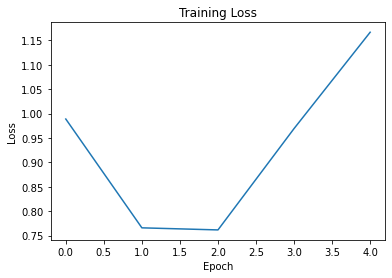

In [11]:
plt.plot(losses_per_epoch)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")

In [20]:
correct = 0
model.eval() 
torch.no_grad()
for sample in tqdm(test_dl, desc="test"):
    
    input_tensor = torch.tensor(converter.subseq2arr(sample.y, input_length, 0, 0)).unsqueeze(0).to(device)
    
    predictions = model(input_tensor)
    predicted_index = predictions.argmax(-1)
    predicted_number = predicted_index[0, -1].item()

    step = 0
    while (predicted_number != 2 and step < max_seq_length):  # Disable gradient computation for inference
        input_tensor = torch.roll(input_tensor, -1, dims=1)
        input_tensor[0, -1] = predicted_number
    
        predictions = model(input_tensor)
        predicted_index = predictions.argmax(-1)  # Get the index of the max log-probability for the last position
        predicted_number = predicted_index[0, -1].item()  # Convert to Python number
        step += 1
     
    input_tensor = torch.roll(input_tensor, -1, dims=1)
    input_tensor[0, -1] = predicted_number 
    check = converter.arr2seq(input_tensor[0]) == converter.arr2seq(converter.subseq2arr(sample[0].y, input_length, 0, input_length))
    
    print(f"Input Sequence: {sample[0].y}")
    print(f"Predicted Sequence: {converter.arr2seq(input_tensor[0])}")
    print(f"Correct: {check}")
    
    correct += check

print(f"Percentage of correct guesses: {correct / (len(test_dl))}")

test: 100%|██████████| 5/5 [00:00<00:00, 30.34it/s]

Input Sequence: 0.(1.4.*0.);
Predicted Sequence: 4.4.1.1.1.
Correct: False
Input Sequence: 1.0.3.;2.4.;
Predicted Sequence: 4.4.1.1.1.
Correct: False
Input Sequence: 0.1.2.4.;
Predicted Sequence: 4.4.1.1.1.
Correct: False
Input Sequence: 1.3.0.4.;
Predicted Sequence: 4.4.1.1.1.
Correct: False
Input Sequence: 1.4.0.3.;
Predicted Sequence: 4.4.1.1.1.
Correct: False
Percentage of correct guesses: 0.0
